In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

from skorch import NeuralNetClassifier

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_csv('star_classification.csv')

In [3]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
df['class'].replace(['GALAXY', 'QSO', 'STAR'], [0,1,2], inplace=True)

In [6]:
df = df.drop(['obj_ID','alpha','delta',
              'run_ID','rerun_ID','cam_col',
              'field_ID','fiber_ID'], axis = 1)

In [7]:
x_df = df.drop(['class'], axis=1)
num_features = len(x_df.columns)
x_df.head()

,u,g,r,i,z,spec_obj_ID,redshift,plate,MJD
0,23.87882,22.27530,20.39501,19.16573,18.79371,6.543777e+18,0.634794,5812,56354
1,24.77759,22.83188,22.58444,21.16812,21.61427,1.176014e+19,0.779136,10445,58158
2,25.26307,22.66389,20.60976,19.34857,18.94827,5.152200e+18,0.644195,4576,55592
3,22.13682,23.77656,21.61162,20.50454,19.25010,1.030107e+19,0.932346,9149,58039
4,19.43718,17.58028,16.49747,15.97711,15.54461,6.891865e+18,0.116123,6121,56187


In [8]:
num_features

9

In [9]:
y_df = df['class']

In [10]:
scaler = StandardScaler()
inp_data = scaler.fit_transform(x_df)

In [11]:
X_train, X_test, \
y_train, y_test = train_test_split(inp_data,
                                   y_df,
                                   test_size=1/7.0,
                                   random_state=42)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [12]:
batch_size = 64

In [13]:
X_train = torch.tensor(X_train).type(torch.float32)
y_train = y_train.reshape(len(y_train),)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test).type(torch.float32)
y_test = torch.tensor(y_test)

In [14]:
trainloader = DataLoader(TensorDataset(X_train,
                                       y_train),
                         batch_size=batch_size,
                         shuffle=True)

testloader = DataLoader(TensorDataset(X_test,
                                      y_test),
                        batch_size=batch_size,
                        shuffle=False)

In [15]:
class RegularizedNet(NeuralNetClassifier):
    def __init__(self, *args, lambda1 = 0.01, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda1 = lambda1

    def get_loss(self, y_pred, y_true, X = None, training = False):
        loss = super().get_loss(y_pred,
                                y_true,
                                X=X,
                                training=training)

        loss += self.lambda1 * \
                sum([w.abs().sum() for w in self.module_.parameters()])

        return loss

In [16]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim=3, output_dim=3):
        super(LogisticRegression, self).__init__()

        self.linear = nn.Linear(input_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.linear(x)
        out = self.softmax(out)

        return out

In [17]:
def train(model, criterion, optimizer, epochs):
    p = list()

    model.train().to(device)

    for epoch in range(epochs):
        for i, (X, labels) in enumerate(trainloader):
            outputs = model(X.to(device)).to(device)
            loss = criterion(outputs.to(device), labels.to(device)).to(device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            correct = 0
            total = 0
            for X, labels in testloader:
                labels = labels.to(device)
                outputs = model(X.to(device)).to(device)

                _, predicted = torch.max(outputs.data.to(device), 1)
                total += labels.size(0)
                correct += (predicted == labels.reshape(-1)).sum().item()

            accuracy = 100 * correct / total

            p.append(accuracy)

        if (epoch + 1) % 10 == 1:
            print(f'Epoch {epoch}: {correct}/{total} Accuracy: {accuracy:.2f}%')
    return p

In [18]:
model = LogisticRegression(num_features, 3)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.9)
p = train(model, criterion, optimizer, 30)
print(f'max accuracy: {max(p):.2f}, avg: {np.mean(p):.2f}')

Epoch 0: 8766/14286 Accuracy: 61.36%
Epoch 10: 8876/14286 Accuracy: 62.13%
Epoch 20: 8570/14286 Accuracy: 59.99%
max accuracy: 64.01, avg: 61.87


In [19]:
def fit_net(net):
    x = torch.Tensor(X_train)
    y = torch.Tensor(y_train).type(torch.LongTensor)
    x_test = torch.Tensor(X_test)
    net.fit(x, y)
    y_pred = net.predict(x_test)

In [20]:
def plot_model_stats(net):
    f, ax = plt.subplots()
    ax.plot(net.history[:, 'train_loss'], 'b', label='training loss')
    ax2 = ax.twinx()
    ax2.plot(net.history[:, 'valid_acc'], 'r', label='validation accuracy')
    ax.set_xlabel('epoch')
    ax.set_ylabel('training loss')
    ax2.set_ylabel('validaction accuracy')
    f.legend()
    plt.title('Loss vs Accuracy')

Re-initializing module because the following parameters were re-set: input_dim.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5420       0.8699        0.4280  1.2617
      2        0.3868       0.8968        0.3648  1.2307
      3        0.3451       0.9045        0.3366  1.2579
      4        0.3239       0.9088        0.3203  1.2512
      5        0.3107       0.9117        0.3094  1.3407
      6        0.3017       0.9132        0.3017  1.3014
      7        0.2951       0.9157        0.2960  1.2858
      8        0.2900       0.9179        0.2916  1.2142
      9        0.2861       0.9194        0.2881  1.1985
     10        0.2830       0.9209        0.2853  1.1926
     11        0.2805       0.9215        0.2830  1.2267
     12        0.2784       0.9225        0.2811  1.3203
     13        0.2767       0.9236        0.2796  1.1972
     14    

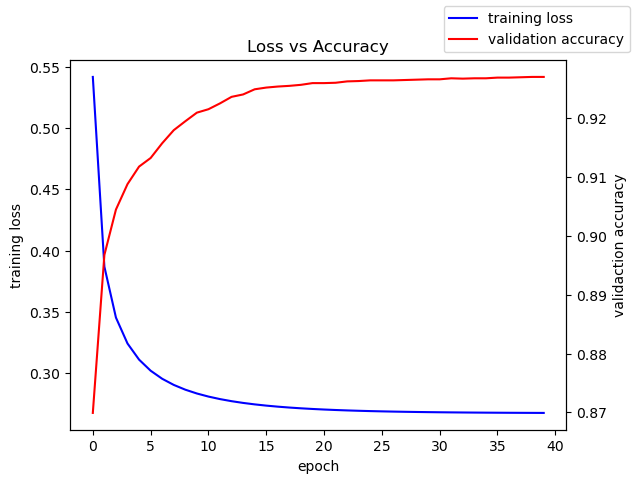

In [21]:
net = RegularizedNet(module = LogisticRegression,
                     max_epochs = 40,
                     criterion = nn.NLLLoss,
                     optimizer = optim.SGD,
                     lr = 0.1,
                     lambda1 = 0,
                     module__input_dim = num_features,
                     optimizer__weight_decay = 0.001,
                     device = device,
                     iterator_train__num_workers = 12,
                     iterator_valid__num_workers = 12)

net.initialize()
fit_net(net)
plot_model_stats(net)

In [22]:
%%time
net = RegularizedNet(module = LogisticRegression,
                     max_epochs = 60,
                     criterion = nn.NLLLoss,
                     optimizer = optim.SGD,
                     lr = 0.1,
                     lambda1 = 0,
                     module__input_dim = num_features,
                     optimizer__weight_decay = 0.001,
                     device = device)

grid = {
    'lr': [1e-2, 2e-3],
    'optimizer__momentum': [0.95, 0.85],
    'optimizer__weight_decay': [0.001, 0.01]
}

gs = GridSearchCV(net,
                  grid,
                  refit=True,
                  cv=5,
                  scoring='accuracy',
                  verbose=1,
                  error_score='raise',
                  n_jobs=-1)

gs.fit(X_train, y_train)

print(gs.best_score_, gs.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5002       0.8845        0.3753  2.4501
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4983       0.8814        0.3778  2.4157
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4942       0.8814        0.3791  2.2523
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4957       0.8812        0.3787  2.2586
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4999       0.8997        0.3790  2.2692
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----

In [23]:
net = RegularizedNet(module = LogisticRegression,
                     max_epochs = 100,
                     criterion = nn.CrossEntropyLoss,
                     optimizer = optim.Adam,
                     lr = 0.01,
                     lambda1 = 0,
                     module__input_dim = num_features,
                     optimizer__weight_decay = 0.001,
                     device = device)

grid = {
    'lr': [1e-2, 2e-3],
    'optimizer__weight_decay': [0.001, 0.01]
}

gs = GridSearchCV(net,
                  grid,
                  refit=True,
                  cv=5,
                  scoring='accuracy',
                  verbose=1,
                  error_score='raise',
                  n_jobs=4)

gs.fit(X_train, y_train)

print(gs.best_score_, gs.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9091       0.7500        0.8237  0.9095
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9030       0.7402        0.8297  0.9107
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8947       0.7422        0.8186  0.9464
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9069       0.7436        0.8191  0.9331
      2        0.7837       0.8511        0.7581  0.4382
      2        0.7864       0.8492        0.7592  0.4412
      2        0.7959       0.8509        0.7615  0.5048
      2        0.8020       0.8419        0.7699  0.5113
      3        0.7435       